DATA BEFORE CLEANING
<class 'pandas.core.frame.DataFrame'>
Index: 1185676 entries, 2014 to 2019
Data columns (total 33 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   YearEnd                    1185676 non-null  int64  
 1   LocationAbbr               1185676 non-null  object 
 2   LocationDesc               1185676 non-null  object 
 3   DataSource                 1185676 non-null  object 
 4   Topic                      1185676 non-null  object 
 5   Question                   1185676 non-null  object 
 6   Response                   0 non-null        float64
 7   DataValueUnit              1033553 non-null  object 
 8   DataValueType              1185676 non-null  object 
 9   DataValue                  806942 non-null   object 
 10  DataValueAlt               804578 non-null   float64
 11  DataValueFootnoteSymbol    393710 non-null   object 
 12  DatavalueFootnote          393710 non-null   object 
 

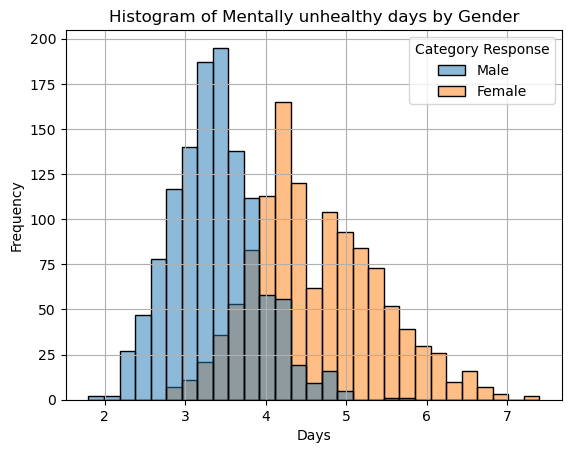

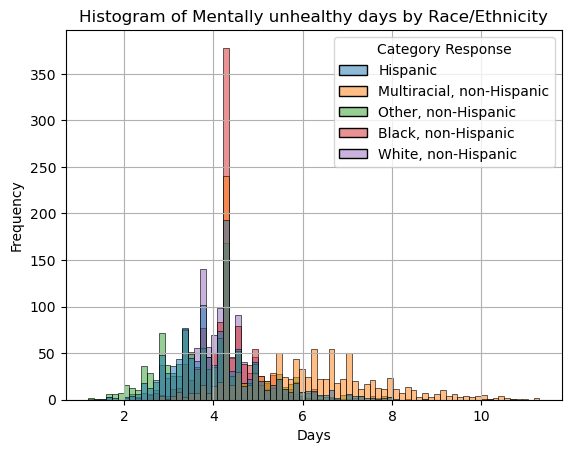

DATA AFTER CLEANING
<class 'pandas.core.frame.DataFrame'>
Index: 8977 entries, 2020 to 2020
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   YearEnd            8977 non-null   int64  
 1   State              8977 non-null   object 
 2   Topic              8977 non-null   object 
 3   Question           8977 non-null   object 
 4   Unit               8977 non-null   object 
 5   Measurement        8977 non-null   object 
 6   DataValue          8977 non-null   object 
 7   Value              8977 non-null   float64
 8   DatavalueFootnote  8977 non-null   object 
 9   Low Confidence     8977 non-null   float64
 10  High Confidence    8977 non-null   float64
 11  Category           8977 non-null   object 
 12  Category Response  8977 non-null   object 
 13  StratificationID1  8977 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.0+ MB
           YearEnd                 State   T

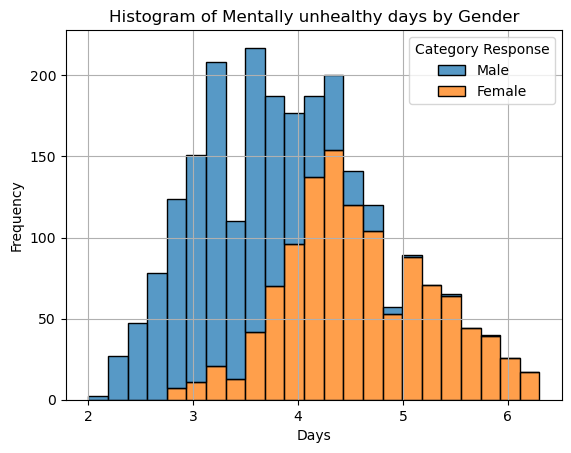

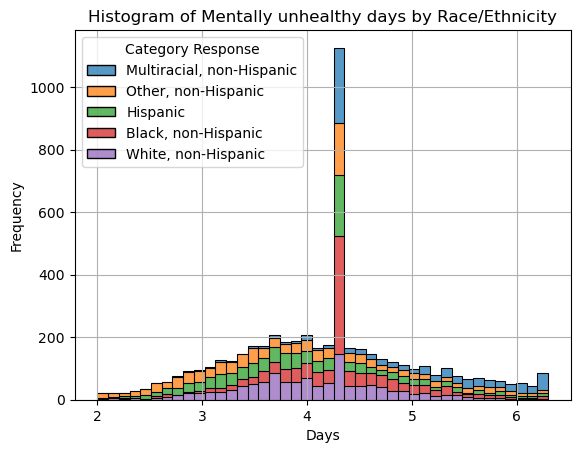

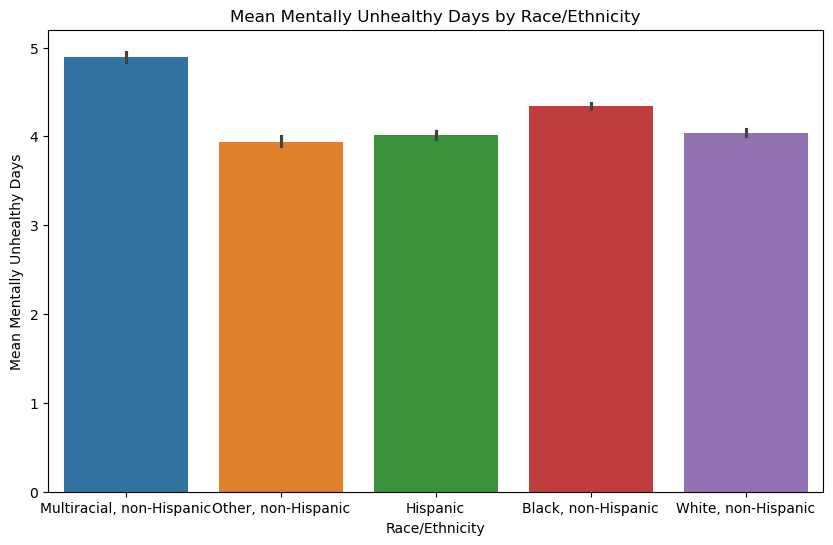

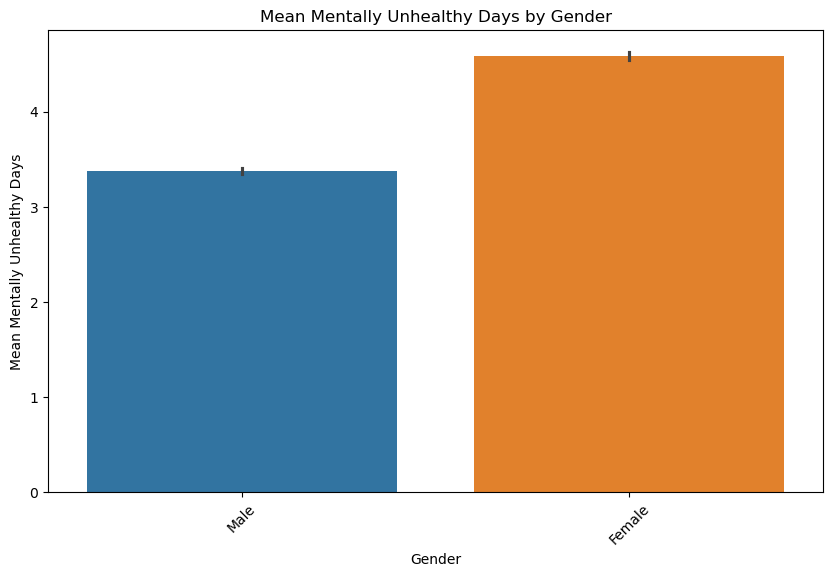

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Loads the dataset into a DataFrame
df = pd.read_csv('dataset.csv', low_memory=False) 

# Sets index as column 'YearStart'
df.set_index('YearStart', inplace=True)

# Provides information on the unfiltered contents of the DataFrame
print('DATA BEFORE CLEANING')
print(df.info())

# Drops columns with 100% null values
df.dropna(axis=1, how='all', inplace=True)

# Drops columns irrelevant to discussion topic
columns_to_drop = [
    'LocationAbbr', 'DataSource', 'DataValueFootnoteSymbol',
    'GeoLocation', 'LocationID', 'TopicID', 'QuestionID',
    'DataValueTypeID', 'StratificationCategoryID1', 'StratificationID1, DataValue'
]
current_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=current_columns_to_drop, inplace=True)

# Renames remaining column names
df.rename(columns={
    'LocationDesc': 'State',
    'DataValueUnit': 'Unit',
    'DataValueType': 'Measurement',
    'DataValueAlt': 'Value',
    'DataValueFootnote': 'Notes',
    'LowConfidenceLimit': 'Low Confidence',
    'HighConfidenceLimit': 'High Confidence',
    'StratificationCategory1': 'Category',
    'Stratification1': 'Category Response'
}, inplace=True)

# Filters data by chosen topic (Mental Health) and question (Recent mentally unhealthy days among adults aged >= 18 years)
df['Topic'] = df['Topic'].str.lower().str.strip()  # Converts topic entries to lower case
df_crop = df[df['Topic'] == 'mental health'].copy()
df_crop['Question'] = df_crop['Question'].str.lower().str.strip()  # Converts questions to lower case
df_crop = df_crop[df_crop['Question'] == 'recent mentally unhealthy days among adults aged >= 18 years']

# Fills in missing values with mean (for numerical) and N/A (for categorical)
for column in df_crop.columns:
    if df_crop[column].dtype == 'object': 
        df_crop[column] = df_crop[column].fillna('N/A')
    else:  
        df_crop[column] = df_crop[column].fillna(df_crop[column].mean())

# Removes duplicate entries
df_crop.drop_duplicates(inplace=True)

# Drops rows with NaN values
df_crop.dropna(inplace=True)

# Initial visualisation (Histogram) of number of days by Gender
sns.histplot(data=df_crop[df_crop['Category'] == 'Gender'], x='Value', hue='Category Response')
plt.title('Histogram of Mentally unhealthy days by Gender')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Initial visualisation (Histogram) of number of days by Race/Ethnicity
sns.histplot(data=df_crop[df_crop['Category'] == 'Race/Ethnicity'], x='Value', hue='Category Response')
plt.title('Histogram of Mentally unhealthy days by Race/Ethnicity')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Drops outlier values using the IQR method
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1 #Subtracts first quartile from third quartile to get the interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_crop = handle_outliers(df_crop, 'Value')  # Removes outliers from 'Value column'

# Aggregates data into single entry with the mean as the Value
df_aggregated = df_crop.groupby(['YearEnd', 'Category', 'Category Response']).agg({
    'Value': 'mean',
}).reset_index()

# Provides information on the cleaned and filtered contents of the DataFrame
print('DATA AFTER CLEANING')
df_crop.info()
print(df.head())

# Mean and standard deviation of mentally unhealthy days by gender
gender_stats = df_crop[df_crop['Category'] == 'Gender'].groupby('Category Response')['Value'].agg(['mean', 'std'])
print("Gender Statistics:\n", gender_stats)

# Mean and standard deviation of mentally unhealthy days by race/ethnicity
race_stats = df_crop[df_crop['Category'] == 'Race/Ethnicity'].groupby('Category Response')['Value'].agg(['mean', 'std'])
print("Race/Ethnicity Statistics:\n", race_stats)

# Visualisation (Histogram) of number of days by Gender AFTER outliers have been removed
sns.histplot(data=df_crop[df_crop['Category'] == 'Gender'], x='Value', hue='Category Response', multiple='stack')
plt.title('Histogram of Mentally unhealthy days by Gender')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualisation (Histogram) of number of days by Race/Ethnicity AFTER outliers have been removed
sns.histplot(data=df_crop[df_crop['Category'] == 'Race/Ethnicity'], x='Value', hue='Category Response', multiple='stack')
plt.title('Histogram of Mentally unhealthy days by Race/Ethnicity')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Drops rows where DataValueType is 'Gender'
df_crop = df_crop[df_crop['Measurement'] != 'Gender']

# Analyses relationship between number of days and race/ethnicity
df_race = df_crop[df_crop['Category'] == 'Race/Ethnicity']

# Plots mean days by race/ethnicity
plt.figure(figsize=(10, 6))
sns.barplot(data=df_race, x='Category Response', y='Value', hue='Category Response', estimator=np.mean)
plt.title('Mean Mentally Unhealthy Days by Race/Ethnicity')
plt.xlabel('Race/Ethnicity')
plt.ylabel('Mean Mentally Unhealthy Days')
plt.show()

# Drops rows where DataValueType is 'Race/Ethnicity'
df_crop = df_crop[df_crop['Measurement'] != 'Race/Ethnicity']

# Analyses relationship between number of days and gender
df_gender = df_crop[df_crop['Category'] == 'Gender']

# Plots mean days by gender
plt.figure(figsize=(10, 6))
sns.barplot(data=df_gender, x='Category Response', y='Value', hue='Category Response', estimator=np.mean)
plt.title('Mean Mentally Unhealthy Days by Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Mentally Unhealthy Days')
plt.xticks(rotation=45)
plt.show()
